In [41]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.circuit.library import QFT
from math import gcd
import numpy as np
from IPython.display import display
%matplotlib inline

# Quantum phase estimation

In [84]:
N = 8 # number to factorize
n = np.ceil(np.log2(N)).astype(int) # number of bits to represent N
q = QuantumRegister(2*n, "q") # input qubits
t = QuantumRegister(n, "t") # target qubits
c = ClassicalRegister(2*n, "c") # classical bits

In [100]:
a = 0
while gcd(a, N) > 1:
    a = np.random.randint(2, N) # number possibly coprime with N
print(f"Chosen number a = {a}")

Chosen number a = 3


Uf is a unitary transformation that compute the modular exponentiation of a number 'a' raised to the power of 2^i mod N, with i ranging from 0 to 2n-1. The unitary transformation is defined as:

In [101]:
def Uf(circ):
    for i in range(2*n):
        mod_exp = pow(a, 2**i, N)
        circ.cp(2*np.pi*mod_exp/N, q[i], t)

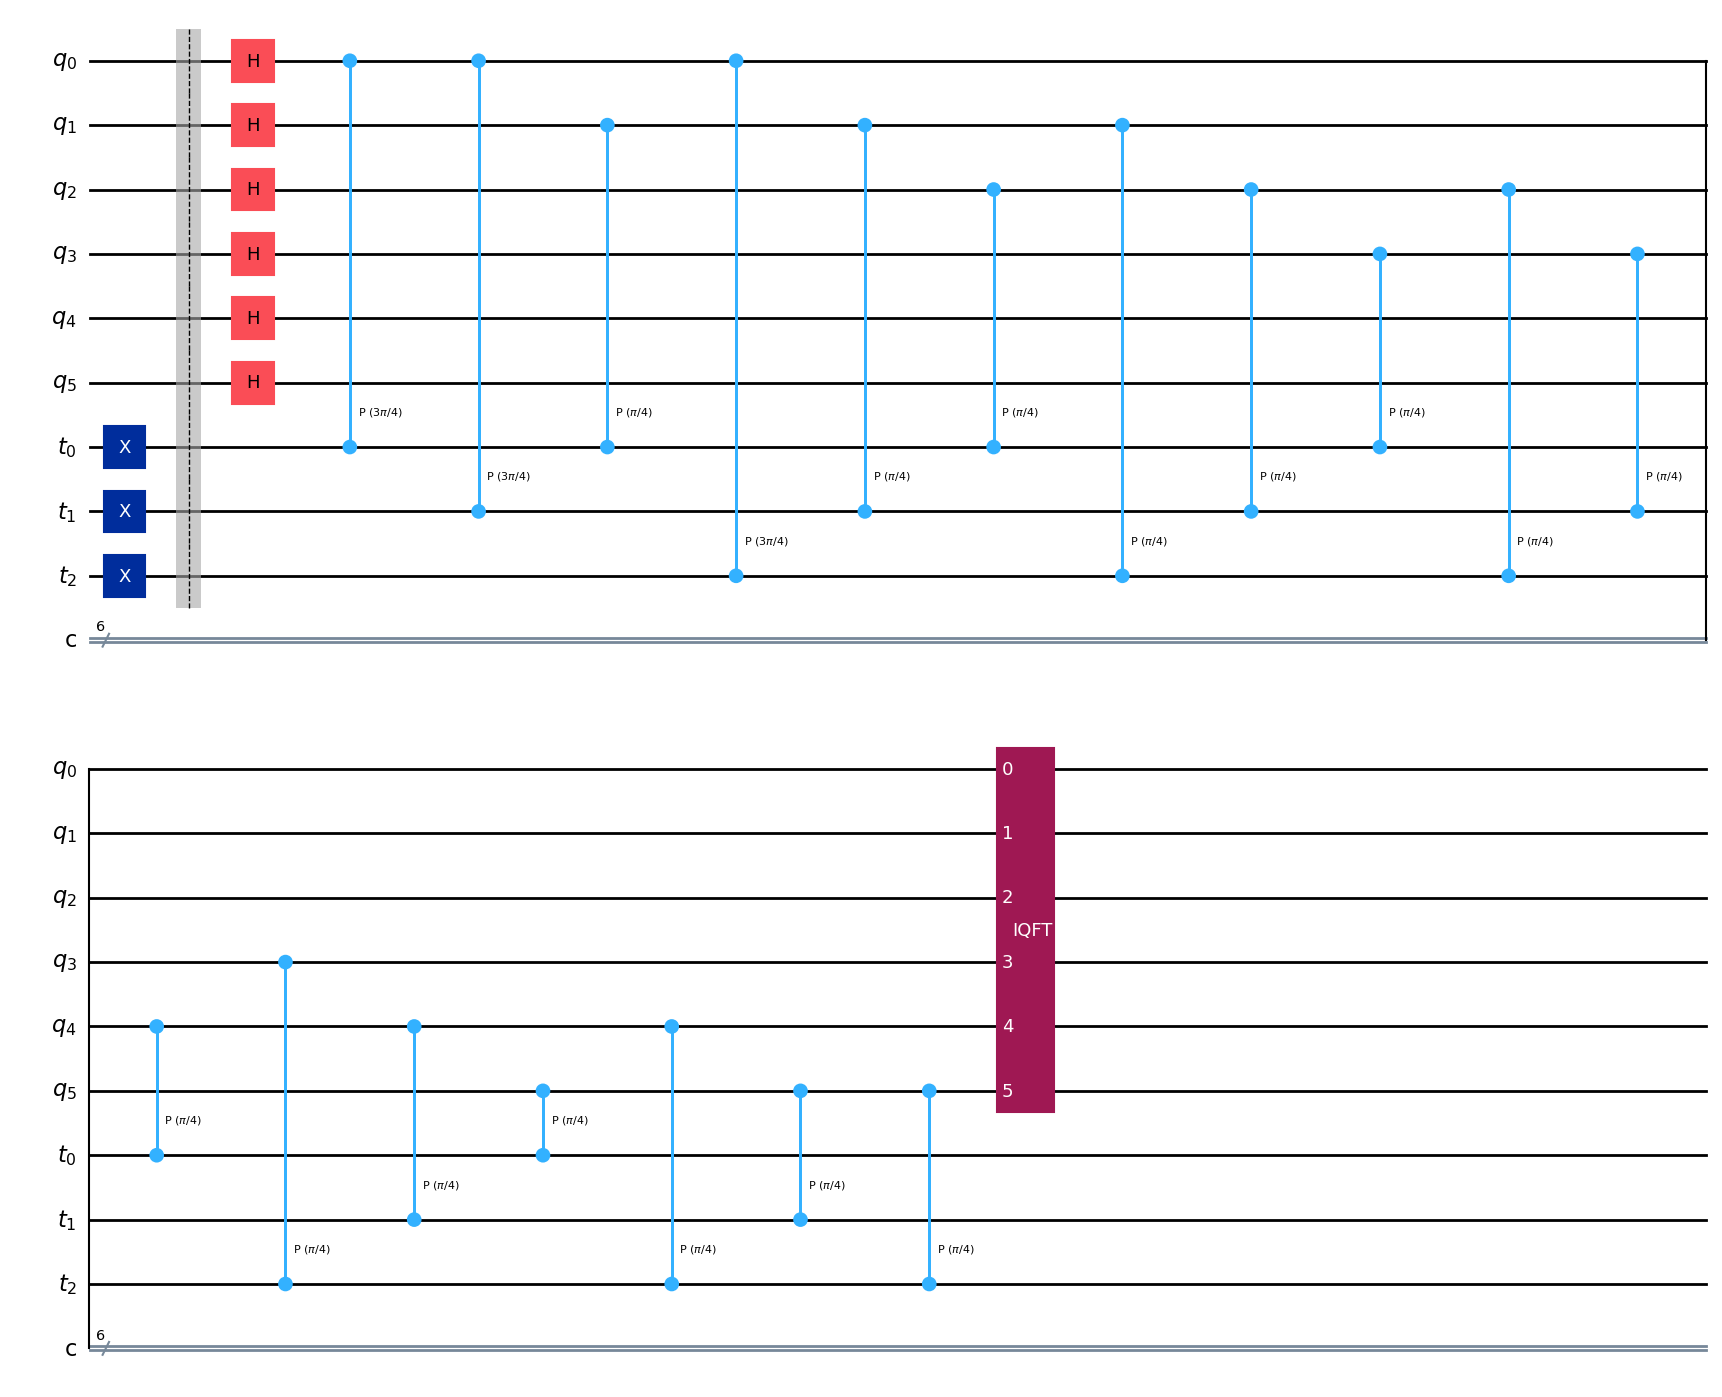

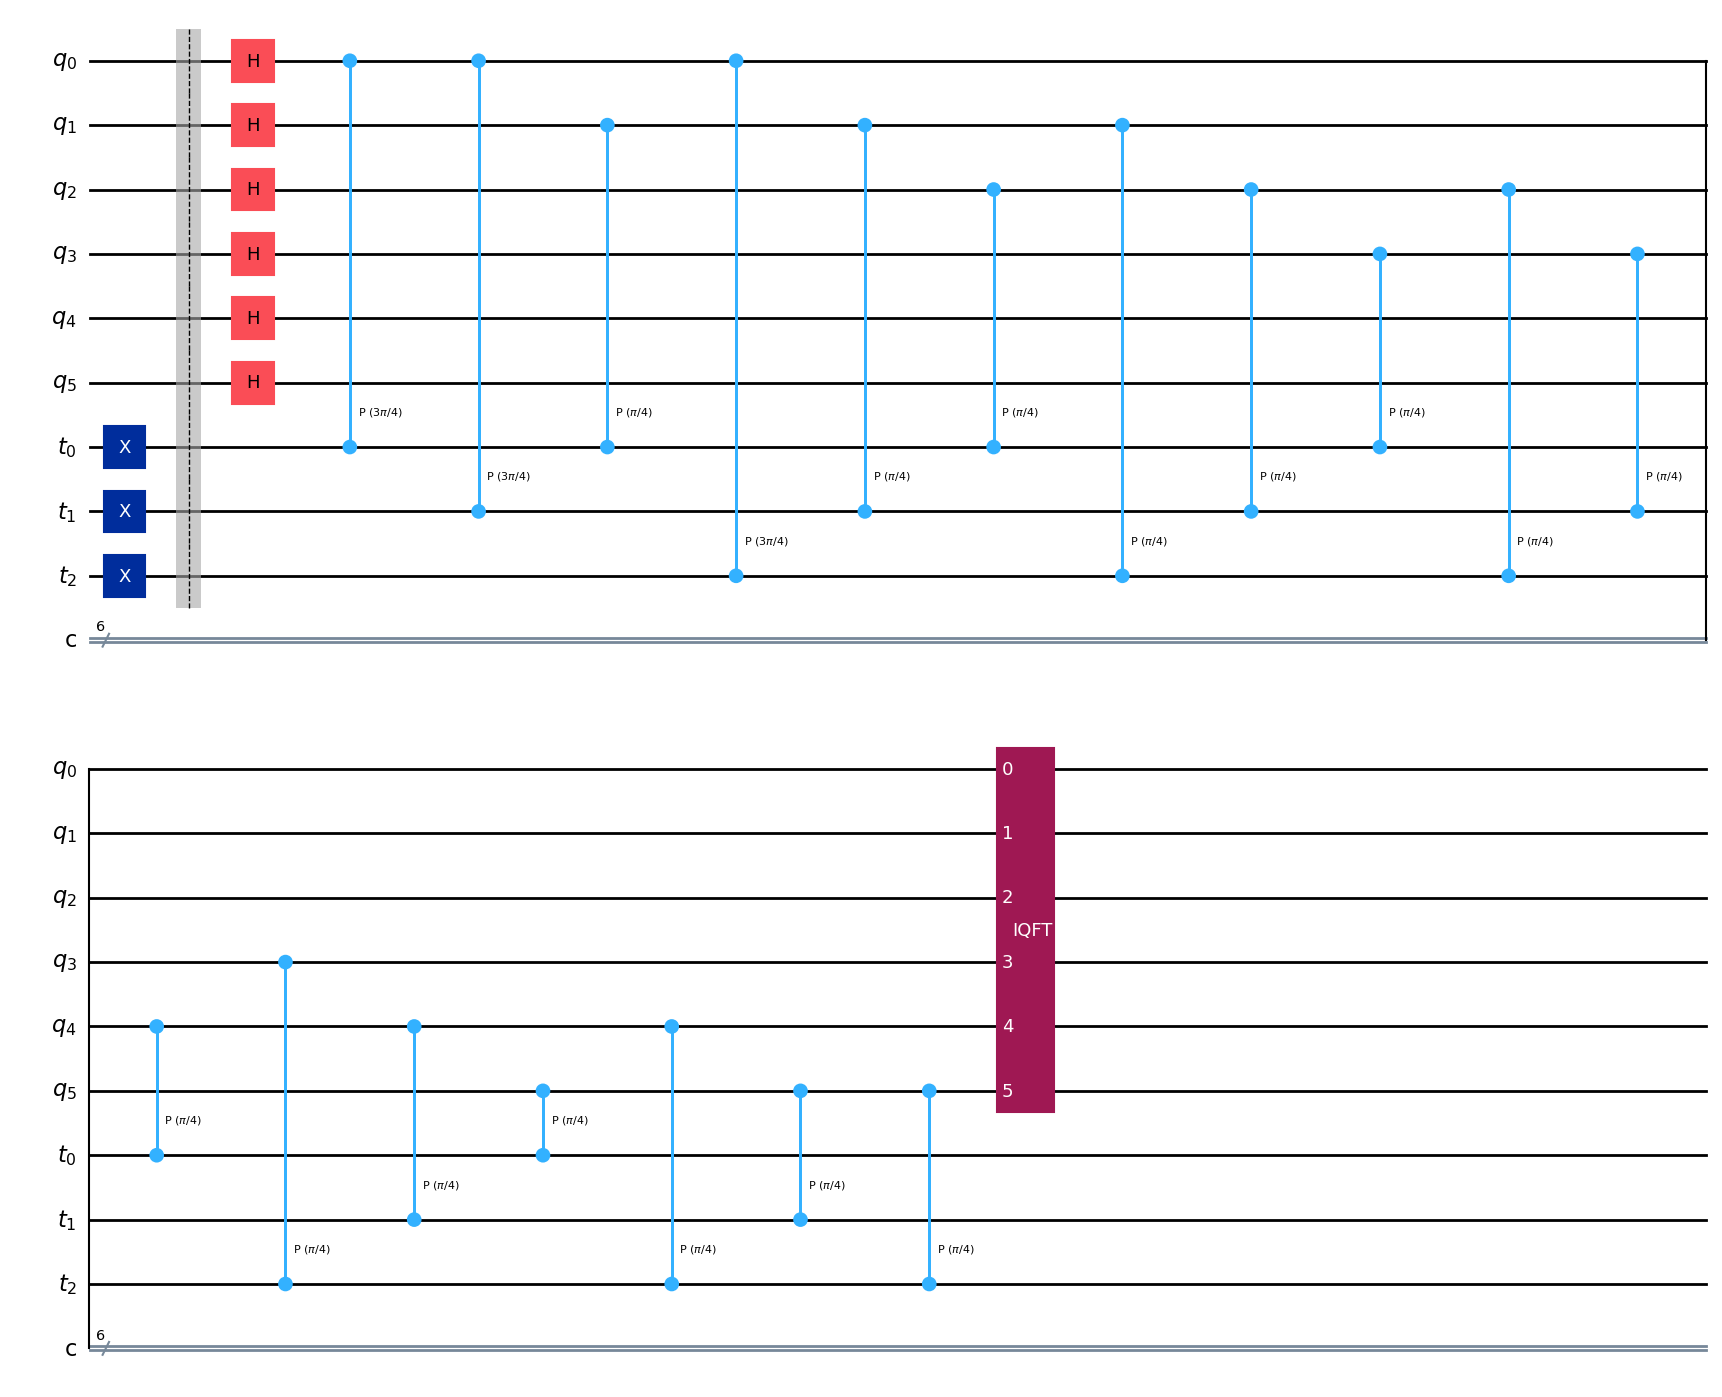

In [107]:
qpe = QuantumCircuit(q, t, c, name="quantum phase estimation")
qpe.x(t) # initialize the target qubits to |1>
qpe.barrier()
qpe.h(q) # apply H-gate to all input qubits
Uf(qpe) # apply modular exponentiation
qpe.append(QFT(2*n, inverse=True), q) # apply the inverse QFT
qpe.draw("mpl")

In [103]:
state = Statevector.from_instruction(qpe)
state.draw("latex")

<IPython.core.display.Latex object>

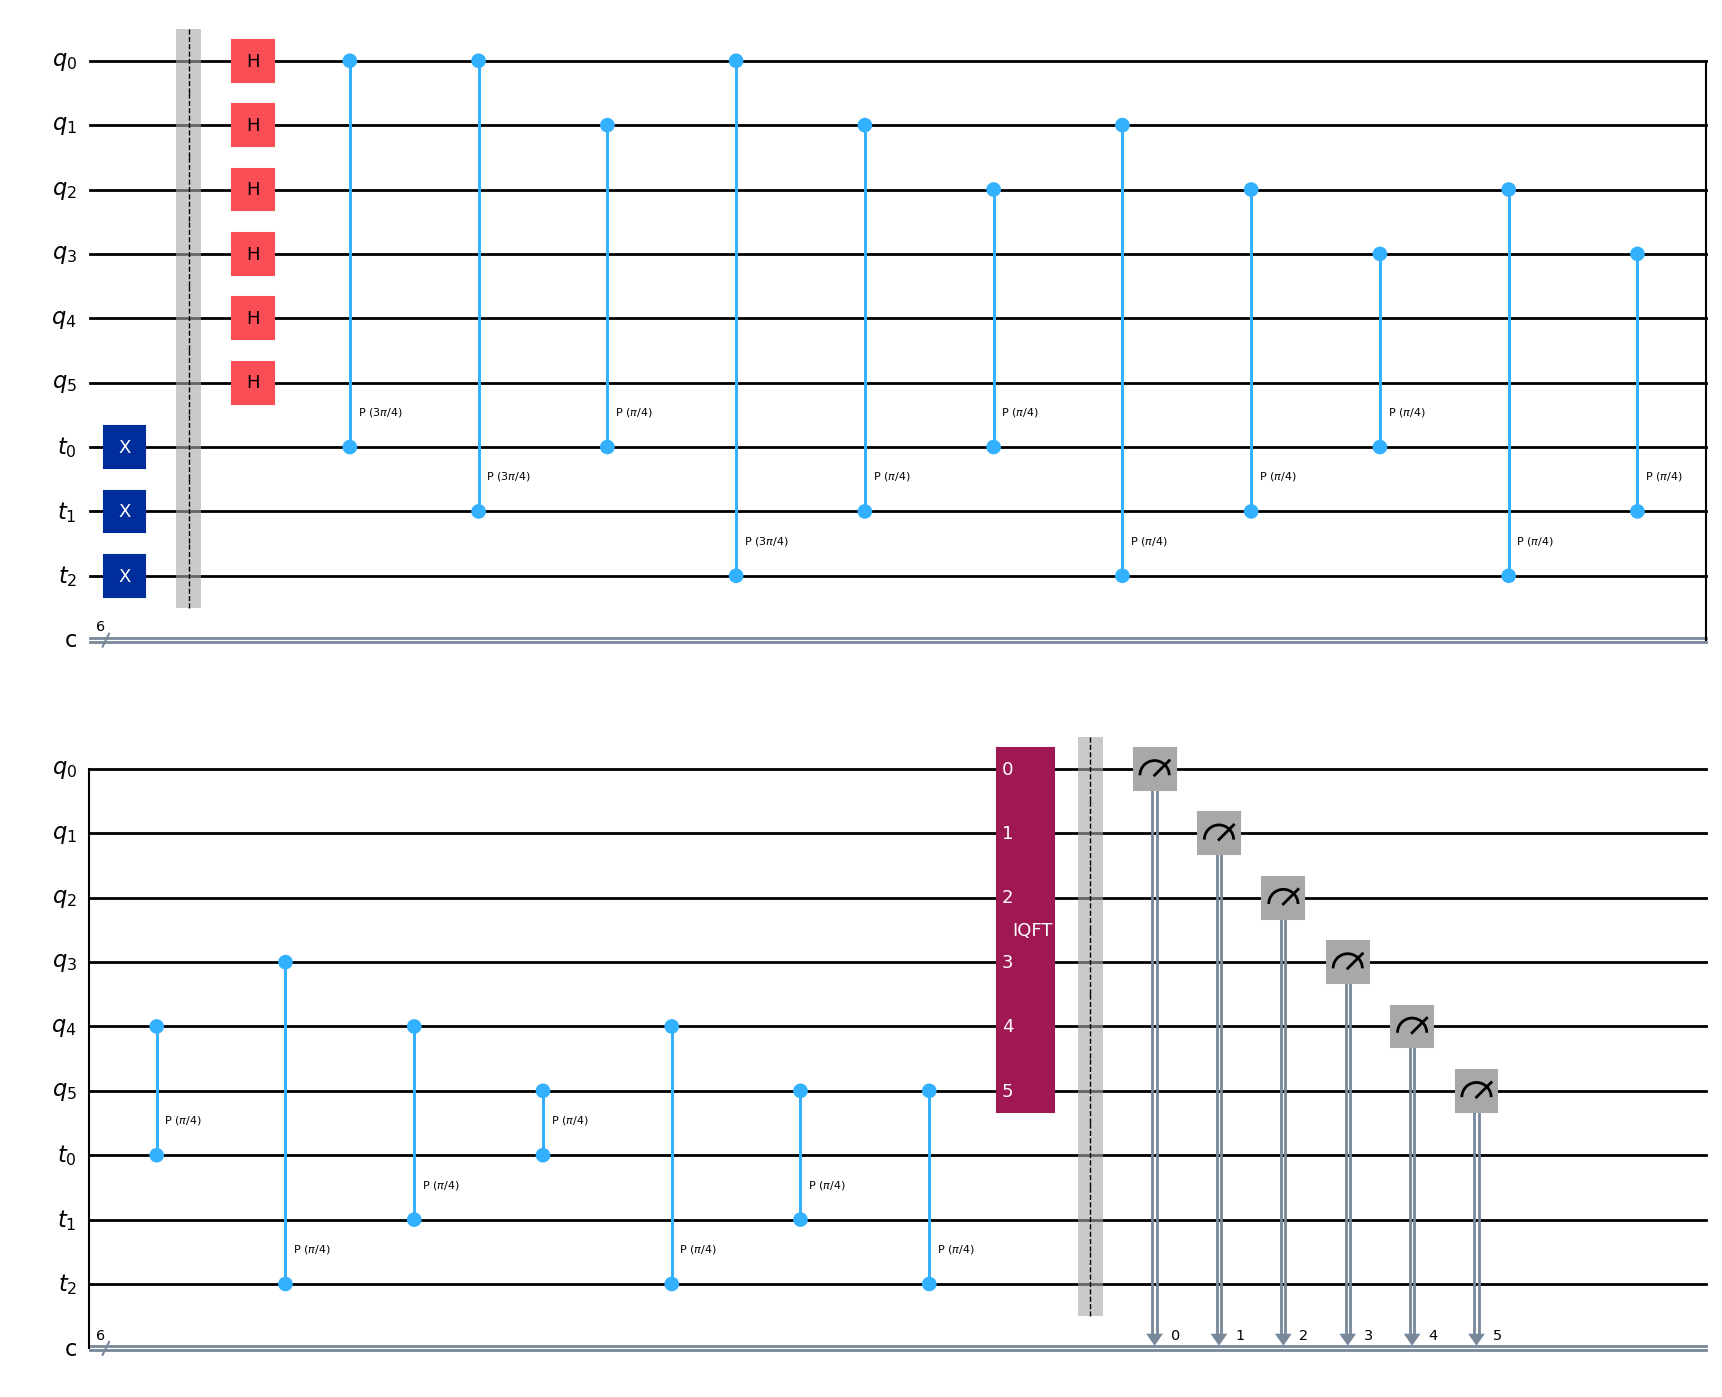

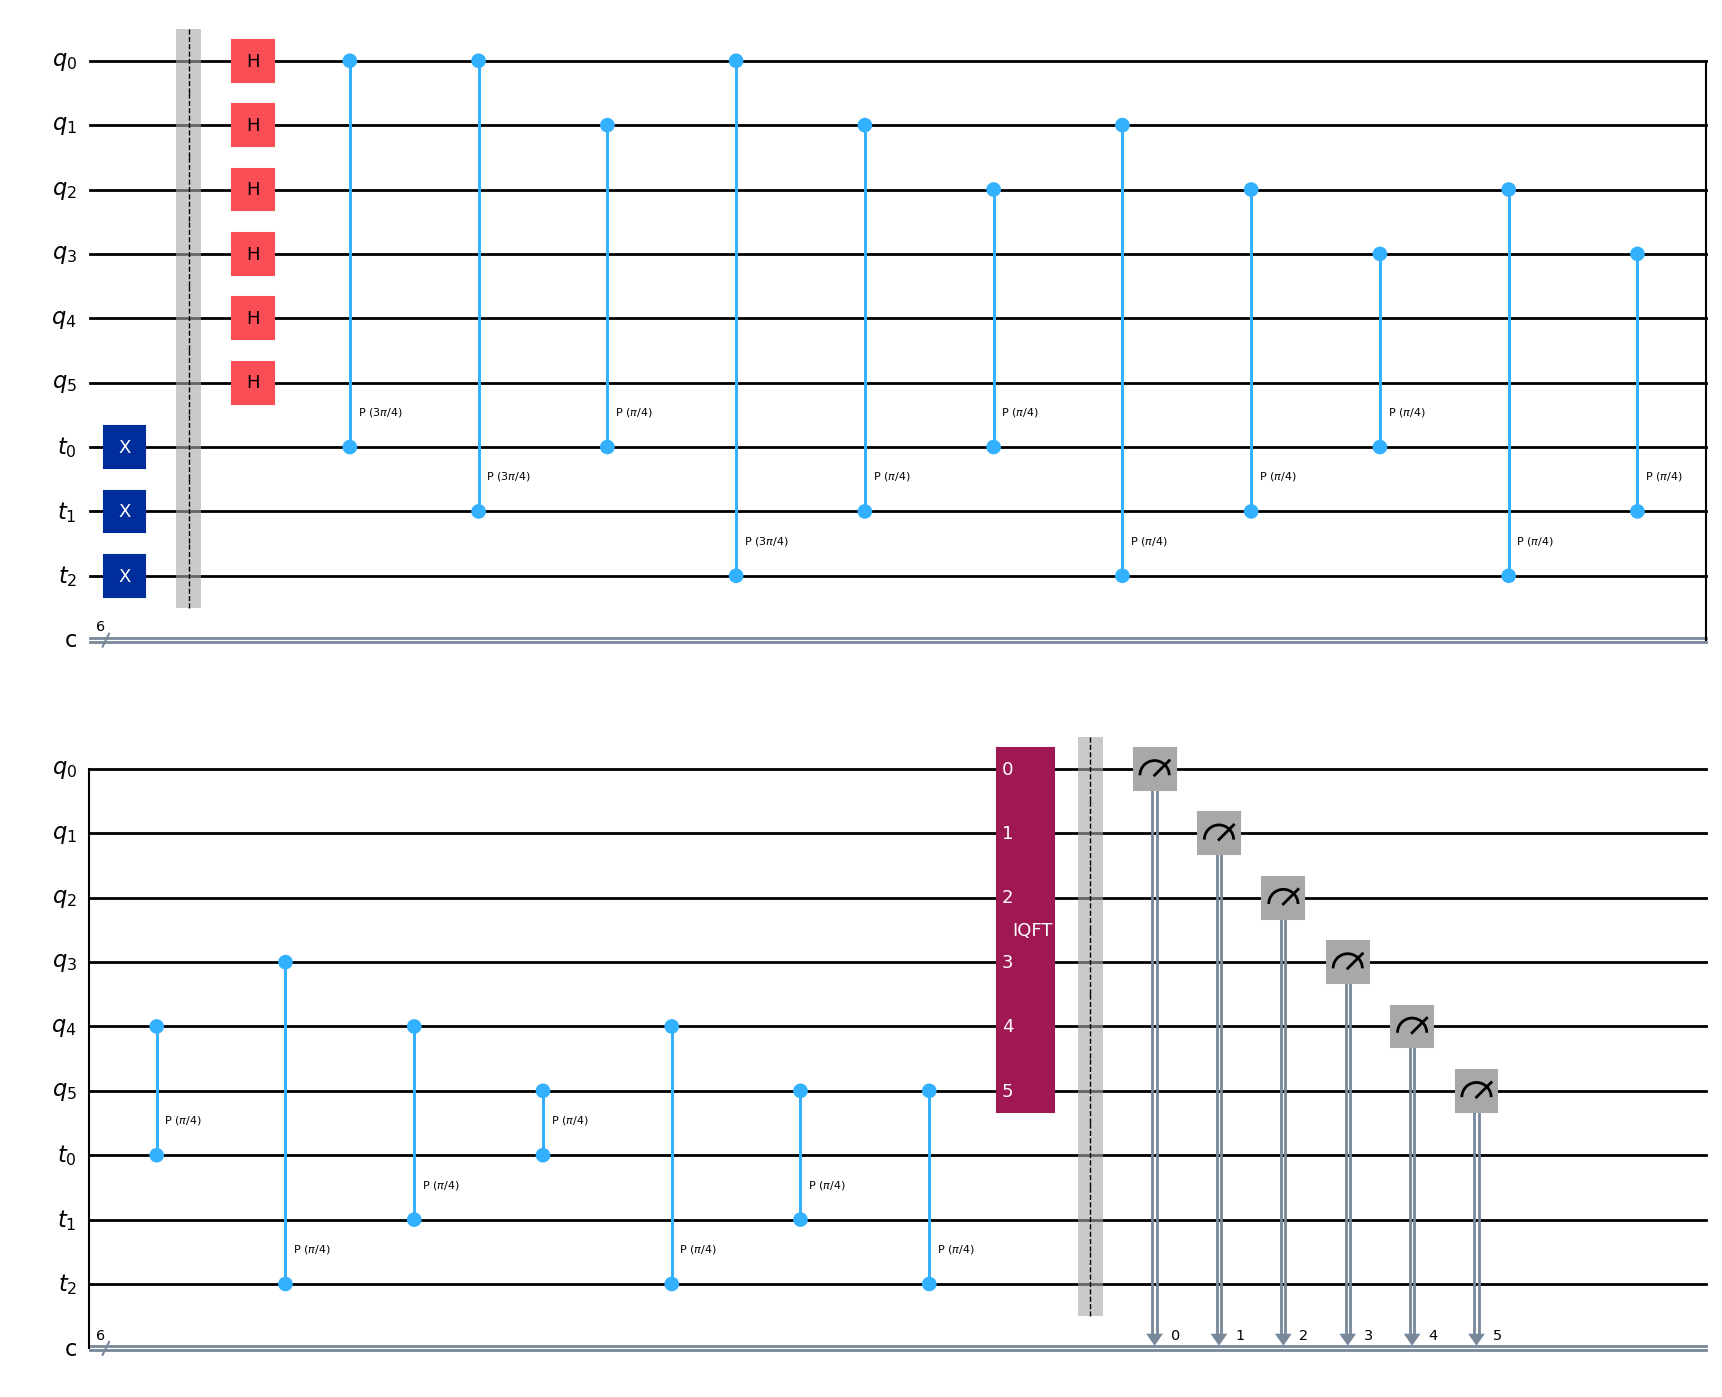

In [104]:
qpe.barrier()
qpe.measure(q, c)
qpe.draw("mpl")

In [105]:
backend = Aer.get_backend('qasm_simulator')
compiled = transpile(qpe, backend)
result = backend.run(compiled, shots=1024).result()
counts = result.get_counts()
print(counts)

{'101001': 1, '010110': 1, '100001': 4, '110001': 16, '001011': 38, '001101': 14, '010010': 31, '010101': 86, '100010': 2, '110010': 8, '001010': 50, '000011': 40, '010001': 59, '000101': 230, '001001': 247, '011010': 2, '110100': 3, '010011': 44, '111001': 13, '011011': 1, '110101': 43, '111010': 1, '000001': 18, '000110': 12, '110011': 13, '011001': 9, '100101': 6, '000100': 6, '000010': 11, '001000': 2, '001100': 3, '100011': 3, '010100': 7}


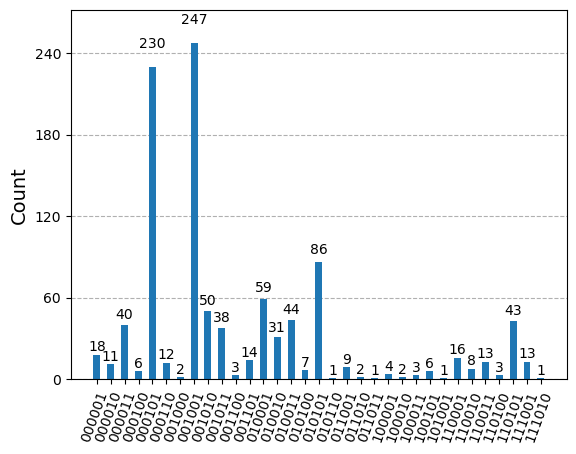

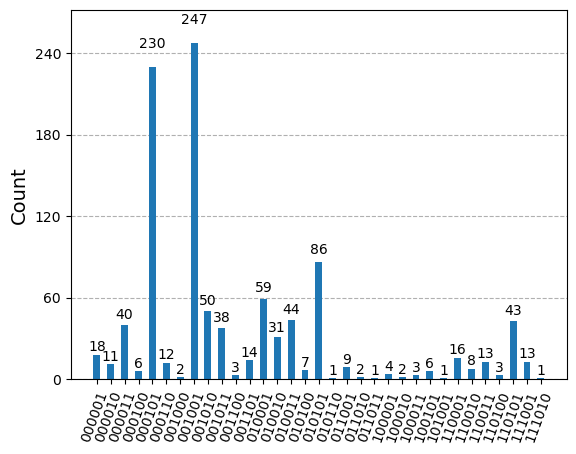

In [106]:
plot_histogram(result.get_counts())